In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import Series
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import traceback

In [2]:
mitig = pd.read_csv("mitigation_cleaned.csv")
country = pd.read_csv("Google_US_only_cleaned.csv")
states_only = pd.read_csv("Google_US_and_states_cleaned.csv")

In [3]:
# convert date columns in each data set to be datetime objects
country.loc[:,'date'] = pd.to_datetime(country['date'])
states_only.loc[:,'date'] = pd.to_datetime(states_only['date'])
mitig.loc[:,'Date'] = pd.to_datetime(mitig['Date'])


In [4]:
mitig = mitig[mitig["County"].isna()] # remove entries related to counties

In [11]:
# Consider the greatest change, either minimum or maximum in the window
window_length = 5
window = np.timedelta64(window_length,'D')
google_mob_categories = states_only.columns[-6:] # mobility data categories


first_date = states_only["date"].unique()[0]
last_date = states_only["date"].unique()[-1]


mobility_val = []


# Lookup states from google data, remove district of columbia
states = states_only["sub_region_1"].unique()
states = np.delete(states, np.where(states == "District of Columbia"))

for state in states:
    # select rows in region after earliest date  and before last date in google data from mitigation data
    mitig_cur_state = mitig.loc[(mitig["State"] == state)]
    mitig_cur_state = mitig_cur_state.loc[(mitig_cur_state["Date"] >= first_date) & (mitig_cur_state["Date"] < (last_date - window))]
    
    mob_cur_state = states_only.loc[states_only["sub_region_1"] == state]
    mob_cur_state = mob_cur_state.loc[(mob_cur_state["date"] >= first_date) & (mob_cur_state["date"] < (last_date - window))]
    try:
        for i,date in enumerate(mitig_cur_state["Date"]):
            new_row = {"state": state}
            new_row.update({"mitigation_date": date})
            new_row.update({"mitigation_type": mitig_cur_state["Mitigation type"].iloc[i]})

            # get min value from each google mob category
            for cat in google_mob_categories:
                
                short_cat_name = cat[:-29]

                # get row index of value in category for states_only between mitigation date and date + window
                where_min = mob_cur_state.loc[(mob_cur_state["date"] >= date) & (mob_cur_state["date"] < date + window)][cat].idxmin()
                
                # also find the maximum value in the window
                where_max = mob_cur_state.loc[(mob_cur_state["date"] >= date) & (mob_cur_state["date"] < date + window)][cat].idxmax()
                
                # add the value
                idx = mob_cur_state.index[mob_cur_state["date"] == date] # index of current date in current state
                mob_at_event = states_only[cat].iloc[idx].values[0] # mobility for category at the date of mitigation event
                
                val_min = states_only[cat].iloc[where_min] - mob_at_event
                val_max = states_only[cat].iloc[where_max] - mob_at_event
                
                # choose the value with the greatest magnitude
                if abs(val_min) > abs(val_max):
                    val = val_min
                    where = where_min
                else:
                    val = val_max
                    where = where_max
                
                new_row.update({"change_" + short_cat_name: val})

                # add the date
                minmax_date = states_only["date"].iloc[where]
                new_row.update({"date_of_change_" + short_cat_name: minmax_date})
                # add the delay
                delay = minmax_date - date
                
                new_row.update({"delay_" + short_cat_name: delay.days})
            mobility_val.append(new_row);
    except IndexError:
        print(f"Error: {state}: {date}: {where}")
        traceback.print_exc()
    except ValueError:
        print(f"Error: {state}: {date}: {where}")
        traceback.print_exc()

mobility_vals_states = DataFrame(mobility_val)

In [12]:
# mean mobility changes by mitigation type in each category
cols = ['change_retail_and_recreation', 'change_grocery_and_pharmacy', 'change_parks', 'change_transit_stations', 'change_workplaces', 'change_residential']
change_table = pd.pivot_table(mobility_vals_states, values=cols, index=['mitigation_type'], aggfunc=np.mean)
change_table

,change_grocery_and_pharmacy,change_parks,change_residential,change_retail_and_recreation,change_transit_stations,change_workplaces
mitigation_type,,,,,,
events cancelled,-6.293103,-12.103448,4.715517,-17.060345,-13.155172,-9.732759
movement restriction,-7.578512,-6.107438,3.008264,-12.975207,-9.578512,-6.909091
new public services,-7.342007,1.282528,-0.130112,-9.223048,-7.724907,-0.624535
non-essential closing,-13.556180,-0.983146,3.533708,-15.876404,-12.994382,-7.286517
other,-7.160714,1.908482,0.772321,-8.870536,-7.531250,-2.191964
public service reduction,-9.500000,7.158537,2.451220,-14.975610,-11.048780,-5.939024
school closing,-5.695652,-8.298137,3.838509,-15.515528,-11.608696,-8.298137
state of emergency,0.971014,-4.536232,3.014493,-11.173913,-8.000000,-7.275362
stay at home,-10.932584,-9.786517,1.179775,-9.988764,-7.258427,-0.550562


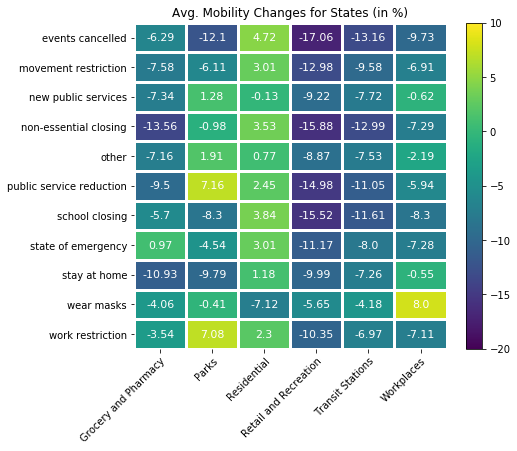

In [13]:
# heat map representation for average mobility changes for all states
change_by_events = change_table.to_numpy()
change_by_events = np.round(change_by_events, decimals=2)

mob_cat = ["Grocery and Pharmacy", "Parks", "Residential", "Retail and Recreation", "Transit Stations", "Workplaces"]
mitig_types = change_table.index
# print(len(mitig_types), drops_by_events.shape)

fig, ax = plt.subplots()
fig.set_size_inches(7,6)
im = ax.imshow(change_by_events, aspect='auto', cmap="viridis", vmin=-20, vmax=10)

ax.set_xticklabels(mob_cat)
ax.set_yticklabels(mitig_types)

ax.set_xticks(np.arange(len(mob_cat)))
ax.set_yticks(np.arange(len(mitig_types)))
  
# Set up white spacing between cells
ax.set_xticks(np.arange(len(mob_cat) + 1) -.5, minor=True)
ax.set_yticks(np.arange(len(mitig_types) + 1) -.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False)
for edge, spine in ax.spines.items():
        spine.set_visible(False)


plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# add text to cells
for i in range(len(mitig_types)):
    for j in range(len(mob_cat)):
        text = ax.text(j, i, change_by_events[i,j], ha="center", va="center", color="w", fontsize=11)

ax.set_title("Avg. Mobility Changes for States (in %)")
cbar = ax.figure.colorbar(im, ax=ax)
plt.show()

In [15]:
# mean delay to mobility drop by mitigation type in each category
cols = ['delay_retail_and_recreation', 'delay_grocery_and_pharmacy', 'delay_parks', 'delay_transit_stations', 'delay_workplaces', 'delay_residential']
delays_table = pd.pivot_table(mobility_vals_states, index=['mitigation_type'], values=cols, aggfunc='mean')
delays_table

,delay_grocery_and_pharmacy,delay_parks,delay_residential,delay_retail_and_recreation,delay_transit_stations,delay_workplaces
mitigation_type,,,,,,
events cancelled,2.844828,2.741379,3.258621,3.370690,3.603448,3.474138
movement restriction,2.818182,2.636364,3.206612,3.239669,3.380165,3.148760
new public services,2.650558,2.561338,2.843866,2.814126,2.780669,2.650558
non-essential closing,2.943820,2.859551,2.960674,3.151685,3.264045,3.033708
other,2.752232,2.524554,2.946429,2.872768,2.977679,2.852679
public service reduction,2.878049,2.634146,3.243902,3.378049,3.256098,3.256098
school closing,2.683230,2.695652,3.273292,3.161491,3.322981,3.248447
state of emergency,2.623188,2.420290,3.289855,3.144928,3.028986,3.333333
stay at home,2.595506,2.516854,3.056180,2.584270,2.820225,2.820225


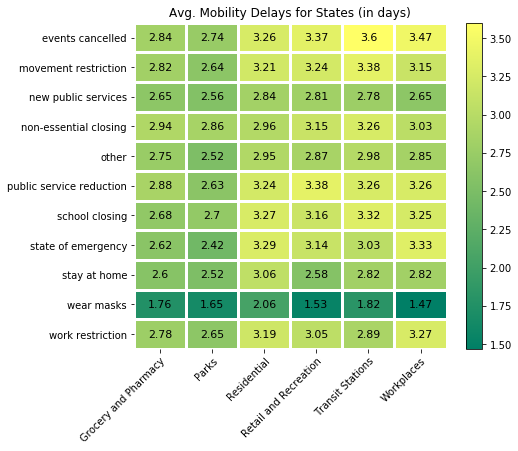

In [16]:
# Create heat map representation of delay data for mobility changes

delays_by_events = delays_table.to_numpy()
delays_by_events = np.round(delays_by_events, decimals=2)

mob_cat = ["Grocery and Pharmacy", "Parks", "Residential", "Retail and Recreation", "Transit Stations", "Workplaces"]
mitig_types = delays_table.index

fig, ax = plt.subplots()
fig.set_size_inches(7,6)
im = ax.imshow(delays_by_events, aspect='auto', cmap="summer")

ax.set_xticklabels(mob_cat)
ax.set_yticklabels(mitig_types)

ax.set_xticks(np.arange(len(mob_cat)))
ax.set_yticks(np.arange(len(mitig_types)))
  
# Set up white spacing between cells
ax.set_xticks(np.arange(len(mob_cat) + 1) -.5, minor=True)
ax.set_yticks(np.arange(len(mitig_types) + 1) -.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False)
for edge, spine in ax.spines.items():
        spine.set_visible(False)


plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# add text to cells
for i in range(len(mitig_types)):
    for j in range(len(mob_cat)):
        text = ax.text(j, i, delays_by_events[i,j], ha="center", va="center", color="k", fontsize=11)

ax.set_title("Avg. Mobility Delays for States (in days)")
cbar = ax.figure.colorbar(im, ax=ax)
plt.show()